In [1]:
import os
import cv2
import sys
import json
import math
import time
import torch
import warnings
import numpy as np
from PIL import Image, ImageDraw
from pathlib import Path

from matplotlib import pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor



from os.path import join as pjoin
# from bop_toolkit_lib import inout
warnings.filterwarnings("ignore")

base_path = os.path.dirname(os.path.abspath("."))
sys.path.append(base_path)

from lib import rendering, network

from dataset import LineMOD_Dataset
from evaluation import utils
from evaluation import config as cfg

gpu_id = 0
# gpu_id = 1

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
os.environ['EGL_DEVICE_ID'] = str(gpu_id)
DEVICE = torch.device('cuda')


datapath = Path(cfg.DATA_PATH)
print(datapath/'lnd2')
eval_dataset = LineMOD_Dataset.Dataset(datapath / 'lnd2')

cfg.RENDER_WIDTH = eval_dataset.cam_width    # the width of rendered images
cfg.RENDER_HEIGHT = eval_dataset.cam_height  # the height of rendered images
cfg.DATASET_NAME = 'lnd2'        # dataset name

cfg.HEMI_ONLY = True   # only the upper hemishpere is used for LineMOD


/home/utsav/IProject/OVE6D-pose/Dataspace/lnd2


# Load Mask-RCNN model

In [8]:

################################################# MASK-RCNN Segmentation ##################################################################
rcnnIdx_to_lmIds_dict = {0:1,1:2}
rcnnIdx_to_lmCats_dict ={0:'lnd2'}
rcnn_cfg = get_cfg()
# rcnn_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
rcnn_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
rcnn_cfg.MODEL.WEIGHTS = os.path.abspath(os.path.join(base_path, 'checkpoints','model_final_res101.pth'))
# rcnn_cfg.MODEL.WEIGHTS = os.path.abspath(os.path.join(base_path, 'checkpoints','model_final_res50.pth'))
rcnn_cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(rcnnIdx_to_lmCats_dict)
rcnn_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.001 # the predicted category scores
predictor = DefaultPredictor(rcnn_cfg)
################################################# MASK-RCNN Segmentation ##################################################################
print('Mask-RCNN has been loaded!')

Mask-RCNN has been loaded!


# Load OVE6D model

In [5]:

ckpt_file = pjoin(base_path, 
                'checkpoints', 
                "OVE6D_pose_model.pth"
                )
model_net = network.OVE6D().to(DEVICE)

model_net.load_state_dict(torch.load(ckpt_file))
model_net.eval()
print('OVE6D has been loaded!')

OVE6D has been loaded!


#  Load object viewpoint codebooks

In [6]:

cfg.VIEWBOOK_BATCHSIZE = 200 # reduce this if out of GPU memory, 
codebook_saving_dir = pjoin(base_path,'evaluation/object_codebooks',
                            cfg.DATASET_NAME, 
                            'zoom_{}'.format(cfg.ZOOM_DIST_FACTOR), 
                            'views_{}'.format(str(cfg.RENDER_NUM_VIEWS)))


object_codebooks = utils.OVE6D_codebook_generation(codebook_dir=codebook_saving_dir, 
                                                    model_func=model_net,
                                                    dataset=eval_dataset, 
                                                    config=cfg, 
                                                    device=DEVICE)
print('Object codebooks have been loaded!')

Loading  /home/utsav/IProject/OVE6D-pose/evaluation/object_codebooks/lnd2/zoom_0.01/views_4000/lnd2_obj_01_views_4000.npy
Object codebooks have been loaded!


# Object segmentation and pose estimation 

raw R tensor([[-0.4072, -0.0498,  0.9120],
        [-0.8523, -0.3382, -0.3990],
        [ 0.3283, -0.9398,  0.0953]]) raw t tensor([-28.9384,  -3.1041, 102.6547])
icp R tensor([[ 0.1447, -0.4422,  1.8790],
        [ 0.1930, -1.6777, -0.2835],
        [ 1.8072, -0.2138, -0.1653]]) raw t tensor([ 19.7548, 170.5813, 111.9183])
icpk R tensor([[-1.1538, -0.9446, -1.9918],
        [ 0.5542, -1.6192, -0.1128],
        [-2.4215, -0.1268,  1.1932]]) raw t tensor([  5.1918, 142.2637,  84.4421])
0
{0: 'lnd2'}
object: lnd2, the 0-th (1.000) RCNN prediction is selected for estimating 6D pose. 
RCNN confs: [1.]


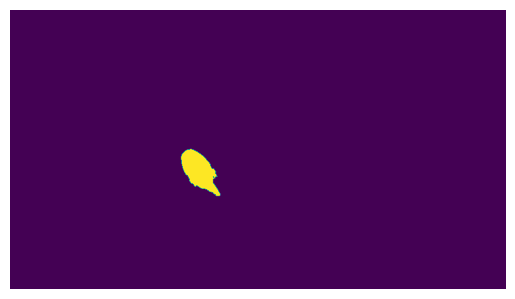

In [9]:

cfg.VP_NUM_TOPK = 50   # the retrieval number of viewpoint 
cfg.RANK_NUM_TOPK = 5  # the ranking number of full 3D orientation 



test_data_dir = datapath / 'lnd2' / 'test'          # path to the test dataset of BOP
obj_renderer = rendering.Renderer(width=cfg.RENDER_WIDTH, height=cfg.RENDER_HEIGHT)

scene_id = 1   # range [1, 15]
view_id = 480  # range [0, 1214]

scene_dir = pjoin(test_data_dir, '{:06d}'.format(scene_id))
color_file = pjoin(scene_dir, 'rgb/{:06d}.png'.format(view_id))
depth_file = pjoin(scene_dir, 'depth/{:06d}.png'.format(view_id))
mask_file = pjoin(scene_dir, 'mask_visib/{:06d}_{:06d}.png'.format(view_id, 0))

tar_obj_id = scene_id # object id equals the scene id for LM dataset
tar_obj_codebook = object_codebooks[tar_obj_id]

############## read the camera information ##############
cam_info_file = pjoin(scene_dir, 'scene_camera.json')
with open(cam_info_file, 'r') as cam_f:
    scene_camera_info = json.load(cam_f)
view_cam_info = scene_camera_info[str(view_id)]  # scene camera information        


############## read the ground truth pose for calculating errors ##############
gt_pose_file = os.path.join(scene_dir, 'scene_gt.json')
with open(gt_pose_file, 'r') as pose_f:
    pose_anno = json.load(pose_f)
view_pose = pose_anno[str(view_id)][0]
obj_gt_R = cfg.BOP_REF_POSE(torch.tensor(view_pose['cam_R_m2c'], dtype=torch.float32).view(3, 3))
obj_gt_t = torch.tensor(view_pose['cam_t_m2c'], dtype=torch.float32) * cfg.MODEL_SCALING


############## read the depth images and covert it from meter to millimeter ##############
# view_depth = torch.tensor(np.array(Image.open(depth_file)), dtype=torch.float32) # HxW
view_depth = torch.tensor(np.array(Image.open(depth_file), dtype=np.float32)) # HxW

view_depth *= view_cam_info['depth_scale']
view_depth *= cfg.MODEL_SCALING # convert to meter scale from millimeter scale
view_camK = torch.tensor(view_cam_info['cam_K'], dtype=torch.float32).view(3, 3)[None, ...] # 1x3x3
cam_K = view_camK.to(DEVICE)
view_depth = view_depth.to(DEVICE)


############## read rgb image for object segmentation ##############
view_timer = time.time() 
rgb_img = cv2.imread(color_file)
imread_cost = time.time() - view_timer

rcnn_timer = time.time()
output = predictor(rgb_img)
rcnn_pred_ids = output["instances"].pred_classes
rcnn_pred_masks = output["instances"].pred_masks
rcnn_pred_scores = output["instances"].scores
rcnn_cost = time.time() - rcnn_timer


## using gt mask ##
# Ground truth mask and depth association
# Load the ground truth binary mask (HxW format), where the mask is already binary
gt_mask_binary = torch.tensor(np.array(Image.open(mask_file)), dtype=torch.bool).to(DEVICE)  # HxW

# Add a batch dimension to match the format of predicted masks
obj_masks = gt_mask_binary.unsqueeze(0)  # 1xHxW (boolean tensor with True/False values)

# Depth map associated with the object mask
obj_depths = view_depth[None, ...] * obj_masks  # Depth information corresponding to the mask

tar_obj_depths = obj_depths  # No filtering by ID, directly assign the depth map
tar_obj_masks = obj_masks    # No filtering by ID, directly assign the ground truth mask

# Simulate score based on the mask's visible area (since we don't have RCNN scores)
tar_obj_scores = torch.ones(tar_obj_masks.size(0), device=DEVICE)  # Assign a perfect score for ground truth

# If there were multiple masks (unlikely in ground truth, but just in case):
mask_pixel_count = tar_obj_masks.view(tar_obj_masks.size(0), -1).sum(dim=1)
valid_idx = (mask_pixel_count >= 100)  # Apply the same validation check

if valid_idx.sum() == 0:
    mask_visib_ratio = mask_pixel_count / mask_pixel_count.max()
    valid_idx = mask_visib_ratio >= 0.05

tar_obj_masks = tar_obj_masks[valid_idx]  # Select valid masks
tar_obj_depths = tar_obj_depths[valid_idx]  # Select corresponding depths
tar_obj_scores = tar_obj_scores[valid_idx]  # Select corresponding scores
###################### object segmentation ######################




tar_rcnn_d = tar_obj_id - 1
# obj_masks = rcnn_pred_masks # NxHxW
# print(obj_masks)
# obj_depths = view_depth[None, ...] * obj_masks
# tar_obj_depths = obj_depths[tar_rcnn_d==rcnn_pred_ids]
# tar_obj_masks = rcnn_pred_masks[tar_rcnn_d==rcnn_pred_ids]
# tar_obj_scores = rcnn_pred_scores[tar_rcnn_d==rcnn_pred_ids]

# mask_pixel_count = tar_obj_masks.view(tar_obj_masks.size(0), -1).sum(dim=1)
# valid_idx = (mask_pixel_count >= 100)
# if valid_idx.sum() == 0:
#     mask_visib_ratio = mask_pixel_count / mask_pixel_count.max()
#     valid_idx = mask_visib_ratio >= 0.05

# tar_obj_masks = tar_obj_masks[valid_idx] # select the target object instance masks
# tar_obj_depths = tar_obj_depths[valid_idx]
# tar_obj_scores = tar_obj_scores[valid_idx]
# print(tar_obj_scores)
pose_ret, rcnn_idx = utils.OVE6D_rcnn_full_pose(model_func=model_net, 
                                    obj_depths=tar_obj_depths,
                                    obj_masks=tar_obj_masks,
                                    obj_rcnn_scores=tar_obj_scores,
                                    obj_codebook=tar_obj_codebook, 
                                    cam_K=cam_K,
                                    config=cfg, 
                                    device=DEVICE,
                                    obj_renderer=obj_renderer, 
                                    return_rcnn_idx=True
                                    )
del obj_renderer

raw_pose_R = pose_ret['raw_R'] # without ICP
raw_pose_t = pose_ret['raw_t'] # without ICP
print(f'raw R {raw_pose_R} raw t {raw_pose_t}')
icp1_pose_R = pose_ret['icp1_R'] # with ICP after pose selection
icp1_pose_t = pose_ret['icp1_t'] # with ICP after pose selection
print(f'icp R {icp1_pose_R} raw t {icp1_pose_t}')
icpk_pose_R = pose_ret['icpk_R'] # with ICP before pose selection
icpk_pose_t = pose_ret['icpk_t'] # with ICP before pose selection
print(f'icpk R {icpk_pose_R} raw t {icpk_pose_t}')
plt.imshow(tar_obj_masks.sum(dim=0).cpu())
plt.axis(False)
print(tar_rcnn_d)
print(rcnnIdx_to_lmCats_dict)
obj_name = rcnnIdx_to_lmCats_dict[tar_rcnn_d]

print('object: {}, the {}-th ({:.3f}) RCNN prediction is selected for estimating 6D pose. '.format(
    obj_name, rcnn_idx, tar_obj_scores[rcnn_idx]))
print('RCNN confs: {}'.format(tar_obj_scores.cpu().numpy()))

# Run inference on all Images

In [10]:
import os
from os.path import join as pjoin
import torch
import numpy as np
import cv2
from PIL import Image

cfg.VP_NUM_TOPK = 50   # the retrieval number of viewpoint 
cfg.RANK_NUM_TOPK = 5  # the ranking number of full 3D orientation 

test_data_dir = datapath / 'lnd2' / 'test'  # path to the test dataset of BOP
obj_renderer = rendering.Renderer(width=cfg.RENDER_WIDTH, height=cfg.RENDER_HEIGHT)

scene_id = 1  # range [1, 15]
scene_dir = pjoin(test_data_dir, '{:06d}'.format(scene_id))
rgb_dir = pjoin(scene_dir, 'rgb')
depth_dir = pjoin(scene_dir, 'depth')
mask_dir = pjoin(scene_dir, 'mask_visib')
output_dir = pjoin(scene_dir, 'ove6d_output')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

tar_obj_id = scene_id  # object id equals the scene id for LM dataset
tar_obj_codebook = object_codebooks[tar_obj_id]

# Load camera information
cam_info_file = pjoin(scene_dir, 'scene_camera.json')
with open(cam_info_file, 'r') as cam_f:
    scene_camera_info = json.load(cam_f)

# Load ground truth pose information
gt_pose_file = os.path.join(scene_dir, 'scene_gt.json')
with open(gt_pose_file, 'r') as pose_f:
    pose_anno = json.load(pose_f)

# Iterate over all images in the RGB folder
for rgb_filename in os.listdir(rgb_dir):
    if rgb_filename.endswith(".png"):
        # Extract the base name (e.g., 000255 from 000255.png)
        base_name = os.path.splitext(rgb_filename)[0]
        print(f'processing: {rgb_filename}')
        # Set up file paths
        color_file = pjoin(rgb_dir, f'{base_name}.png')
        depth_file = pjoin(depth_dir, f'{base_name}.png')
        mask_file = pjoin(mask_dir, f'{base_name}_000000.png')
        base_name_cam = os.path.splitext(rgb_filename)[0].lstrip('0')

        # Load camera and ground truth pose information
        view_cam_info = scene_camera_info[base_name_cam]
        view_pose = pose_anno[base_name_cam][0]
        obj_gt_R = cfg.BOP_REF_POSE(torch.tensor(view_pose['cam_R_m2c'], dtype=torch.float32).view(3, 3))
        obj_gt_t = torch.tensor(view_pose['cam_t_m2c'], dtype=torch.float32) * cfg.MODEL_SCALING

        # Read the depth image and convert it from meter to millimeter
        view_depth = torch.tensor(np.array(Image.open(depth_file), dtype=np.float32))  # HxW
        view_depth *= view_cam_info['depth_scale']
        view_depth *= cfg.MODEL_SCALING  # convert to meter scale from millimeter scale
        view_camK = torch.tensor(view_cam_info['cam_K'], dtype=torch.float32).view(3, 3)[None, ...]  # 1x3x3
        cam_K = view_camK.to(DEVICE)
        view_depth = view_depth.to(DEVICE)

        # Read RGB image for object segmentation
        rgb_img = cv2.imread(color_file)

        ## using gt mask ##
        # Ground truth mask and depth association
        gt_mask_binary = torch.tensor(np.array(Image.open(mask_file)), dtype=torch.bool).to(DEVICE)  # HxW

        # Add a batch dimension to match the format of predicted masks
        obj_masks = gt_mask_binary.unsqueeze(0)  # 1xHxW (boolean tensor with True/False values)

        # Depth map associated with the object mask
        obj_depths = view_depth[None, ...] * obj_masks  # Depth information corresponding to the mask

        tar_obj_depths = obj_depths  # No filtering by ID, directly assign the depth map
        tar_obj_masks = obj_masks  # No filtering by ID, directly assign the ground truth mask

        # Simulate score based on the mask's visible area (since we don't have RCNN scores)
        tar_obj_scores = torch.ones(tar_obj_masks.size(0), device=DEVICE)  # Assign a perfect score for ground truth

        # Apply validation check
        mask_pixel_count = tar_obj_masks.view(tar_obj_masks.size(0), -1).sum(dim=1)
        valid_idx = (mask_pixel_count >= 100)

        if valid_idx.sum() == 0:
            mask_visib_ratio = mask_pixel_count / mask_pixel_count.max()
            valid_idx = mask_visib_ratio >= 0.05

        tar_obj_masks = tar_obj_masks[valid_idx]  # Select valid masks
        tar_obj_depths = tar_obj_depths[valid_idx]  # Select corresponding depths
        tar_obj_scores = tar_obj_scores[valid_idx]  # Select corresponding scores

        # Perform pose estimation
        pose_ret, rcnn_idx = utils.OVE6D_rcnn_full_pose(model_func=model_net,
                                                        obj_depths=tar_obj_depths,
                                                        obj_masks=tar_obj_masks,
                                                        obj_rcnn_scores=tar_obj_scores,
                                                        obj_codebook=tar_obj_codebook,
                                                        cam_K=cam_K,
                                                        config=cfg,
                                                        device=DEVICE,
                                                        obj_renderer=obj_renderer,
                                                        return_rcnn_idx=True)

        # Extract raw rotation and translation
        raw_pose_R = pose_ret['raw_R']  # without ICP
        raw_pose_t = pose_ret['raw_t']  # without ICP

        # Save the raw rotation and translation as a 3x4 matrix
        raw_pose_matrix = torch.cat([raw_pose_R, raw_pose_t.view(3, 1)], dim=1).cpu().numpy()
        output_file = pjoin(output_dir, f'{base_name}.txt')
        np.savetxt(output_file, raw_pose_matrix, fmt='%.6f')

        print(f'Saved pose matrix for {base_name} to {output_file}')

del obj_renderer


processing: 000273.png
Saved pose matrix for 000273 to /home/utsav/IProject/OVE6D-pose/Dataspace/lnd2/test/000001/ove6d_output/000273.txt
processing: 000615.png
Saved pose matrix for 000615 to /home/utsav/IProject/OVE6D-pose/Dataspace/lnd2/test/000001/ove6d_output/000615.txt
processing: 000789.png
Saved pose matrix for 000789 to /home/utsav/IProject/OVE6D-pose/Dataspace/lnd2/test/000001/ove6d_output/000789.txt
processing: 000268.png
Saved pose matrix for 000268 to /home/utsav/IProject/OVE6D-pose/Dataspace/lnd2/test/000001/ove6d_output/000268.txt
processing: 000685.png
Saved pose matrix for 000685 to /home/utsav/IProject/OVE6D-pose/Dataspace/lnd2/test/000001/ove6d_output/000685.txt
processing: 000900.png
Saved pose matrix for 000900 to /home/utsav/IProject/OVE6D-pose/Dataspace/lnd2/test/000001/ove6d_output/000900.txt
processing: 000302.png
Saved pose matrix for 000302 to /home/utsav/IProject/OVE6D-pose/Dataspace/lnd2/test/000001/ove6d_output/000302.txt
processing: 000643.png
Saved pose 

GT(Red): 	 lnd2, diameter: 13.8mm, pose threshold(0.1d): 13.8mm
Raw(Blue): 	 rot error:178.4˚, tsl_err:8.7mm, add:5.0mm, adi:0.9mm
ICP1(Green): 	 rot error:160.0˚, tsl_err:172.3mm, add:175.4mm, adi:168.6mm
ICPK(Cyan): 	 rot error:82.1˚, tsl_err:142.1mm, add:144.4mm, adi:137.1mm


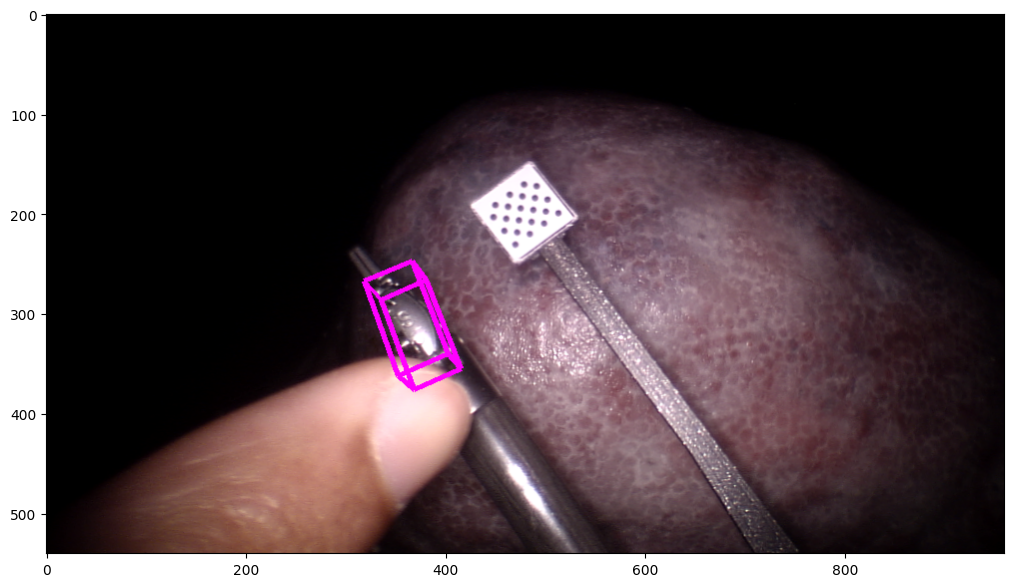

In [24]:
import misc 

obj_mesh = tar_obj_codebook['obj_mesh']

PD_raw_pose = torch.eye(4, dtype=torch.float32)
PD_raw_pose[:3, 3] = raw_pose_t
PD_raw_pose[:3, :3] = cfg.POSE_TO_BOP(raw_pose_R)


PD_icp1_pose = torch.eye(4, dtype=torch.float32)
PD_icp1_pose[:3, 3] = icp1_pose_t
PD_icp1_pose[:3, :3] = cfg.POSE_TO_BOP(icp1_pose_R)


PD_icpk_pose = torch.eye(4, dtype=torch.float32)
PD_icpk_pose[:3, 3] = icpk_pose_t
PD_icpk_pose[:3, :3] = cfg.POSE_TO_BOP(icpk_pose_R)


GT_pose = torch.eye(4, dtype=torch.float32)
GT_pose[:3, :3] = obj_gt_R
GT_pose[:3, 3] = obj_gt_t

obj_diameter = tar_obj_codebook['diameter']
corner_pts = obj_mesh.bounds  # object bounding box vertices
obj_pcl = obj_mesh.vertices
N_pcl = len(obj_pcl)
select_obj_idxes = torch.randperm(N_pcl)[:500]
select_obj_pts = torch.tensor(obj_pcl[select_obj_idxes])

GT_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=GT_pose, K=cam_K)
PD_raw_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=PD_raw_pose, K=cam_K)
PD_icp1_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=PD_icp1_pose, K=cam_K)
PD_icpk_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=PD_icpk_pose, K=cam_K)

GT_shape = misc.bbox_to_shape(GT_2D_bbox.tolist())
PD_raw_shape = misc.bbox_to_shape(PD_raw_2D_bbox.tolist())
PD_icp1_shape = misc.bbox_to_shape(PD_icp1_2D_bbox.tolist())
PD_icpk_shape = misc.bbox_to_shape(PD_icpk_2D_bbox.tolist())


pil_img = Image.open(color_file)
Raw_bbox_img = pil_img.copy()

draw = ImageDraw.Draw(Raw_bbox_img)
# draw.line(GT_shape, (255, 0, 0), 3)      # Red 3D bbox for GT
draw.line(PD_raw_shape, (255, 0, 255), 5)  # Blue 3D bbox for OVE6D


ICP1_bbox_img = pil_img.copy()
draw = ImageDraw.Draw(ICP1_bbox_img)
draw.line(GT_shape, (255, 0, 0), 3)  # Red 3D bbox for GT
draw.line(PD_icp1_shape, (0, 255, 0), 3)  # Green 3D bbox for OVE6D with ICP after pose selection


ICPK_bbox_img = pil_img.copy()
draw = ImageDraw.Draw(ICPK_bbox_img)
draw.line(GT_shape, (255, 0, 0), 3)  # Red 3D bbox for GT
draw.line(PD_icpk_shape, (255, 0, 255), 3)  # Cyan 3D bbox for OVE6D with ICP before pose selection


##### calculate the pose errors ########
raw_R_err = utils.rotation_error(raw_pose_R, obj_gt_R)
icp1_R_err = utils.rotation_error(icp1_pose_R, obj_gt_R)
icpk_R_err = utils.rotation_error(icpk_pose_R, obj_gt_R)

raw_t_err = (((raw_pose_t - obj_gt_t)**2).sum())**0.5 
icp1_t_err = (((icp1_pose_t - obj_gt_t)**2).sum())**0.5 
icpk_t_err = (((icpk_pose_t - obj_gt_t)**2).sum())**0.5 


raw_add_err = misc.add(R_est=raw_pose_R.numpy(), t_est=raw_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())
raw_adi_err = misc.adi(R_est=raw_pose_R.numpy(), t_est=raw_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())

icp1_add_err = misc.add(R_est=icp1_pose_R.numpy(), t_est=icp1_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())
icp1_adi_err = misc.adi(R_est=icp1_pose_R.numpy(), t_est=icp1_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())

icpk_add_err = misc.add(R_est=icpk_pose_R.numpy(), t_est=icpk_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())
icpk_adi_err = misc.adi(R_est=icpk_pose_R.numpy(), t_est=icpk_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())



# fig, ax = plt.subplots(1,3,figsize=(30, 10))
# ax[0].imshow(Raw_bbox_img)
# ax[0].set_title("T(0.1d)={:.1f}mm, Raw R: {:.1f}˚, t: {:.1f}mm, add: {:.1f}mm, adi: {:.1f}mm".format(
#     obj_diameter * 100, raw_R_err, raw_t_err, raw_add_err, raw_adi_err), fontsize=20)
# ax[1].imshow(ICP1_bbox_img)
# ax[1].set_title("T={:.1f}mm, ICP1 R: {:.1f}˚, t: {:.1f}mm, add: {:.1f}mm, adi: {:.1f}mm".format(
#     obj_diameter * 100, icp1_R_err, icp1_t_err, icp1_add_err, icp1_adi_err), fontsize=20)
# ax[2].imshow(ICPK_bbox_img)
# ax[2].set_title("T={:.1f}mm, ICPK R: {:.1f}˚, t: {:.1f}mm, add: {:.1f}mm, adi: {:.1f}mm".format(
#     obj_diameter * 100, icpk_R_err, icpk_t_err, icpk_add_err, icpk_adi_err), fontsize=20)
# ax[0].axis(False)
# ax[1].axis(False)
# ax[2].axis(False)
plt.figure(figsize=(13, 7))  # width=10 inches, height=8 inches

# Display the image
plt.imshow(Raw_bbox_img)

# print('object diameter: {:.1f}mm, 0.1d:{:.1f}mm'.format(obj_diameter, obj_diameter*100))
print('GT(Red): \t {}, diameter: {:.1f}mm, pose threshold(0.1d): {:.1f}mm'.format(obj_name, obj_diameter, obj_diameter))
print('Raw(Blue): \t rot error:{:.1f}˚, tsl_err:{:.1f}mm, add:{:.1f}mm, adi:{:.1f}mm'.format(raw_R_err, raw_t_err, raw_add_err, raw_adi_err))
print('ICP1(Green): \t rot error:{:.1f}˚, tsl_err:{:.1f}mm, add:{:.1f}mm, adi:{:.1f}mm'.format(icp1_R_err, icp1_t_err, icp1_add_err, icp1_adi_err))
print('ICPK(Cyan): \t rot error:{:.1f}˚, tsl_err:{:.1f}mm, add:{:.1f}mm, adi:{:.1f}mm'.format(icpk_R_err, icpk_t_err, icpk_add_err, icpk_adi_err))

